# Accuracy and relation to significance

**Motivation:** We've been having a lot of discussions in the analysis meeting about how the accuracy in the pairing algorithm is something that is good, but then also empirically we have some (analysis peculiarities?) that sometimes it doesn't really matter whether we've gotten the "correct" pair or not, and both options end up inside of our signal region.

So, I wanted to take a step back and really understand how pairing accuracy plays into our significance by looking into the kinematics subsequent variables that we're cutting on and see how getting the "wrong pair" smears out the distributions.


In [23]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr

import os
import sys
sys.path.append("../code")
from analysis import *
from plotting import SR_x,SR_y1,SR_y2, CR_x,CR_y1,CR_y2, SB_x,SB_y1,SB_y2

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 

Running w/ conda env: don't import root packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I'm starting off R&D for the SMNR sample, since this is the signal that I am the most familar with, but I want to leave this configurable so 

In [2]:
prodTag = "AUG2019"
physicsSample = f"SMNR_mc16a_PFlow-{prodTag}"

figDir = "figures/accuracy/"+physicsSample

if not os.path.exists(figDir):
    os.mkdir(figDir)


In [3]:
os.listdir(f"../data/{physicsSample}")

['files', 'df_f_0.22.h5', 'df_f_0.22_3b.h5']

Note: I made the df that I'm loading in below in the `Jet-Vertex-Charge` notebook.

In [4]:
df = pd.read_hdf(f"../data/{physicsSample}/df_f_0.22.h5",key='df')

In [5]:
np.min(df.nbtags)

4

In [6]:
# sigText = "$\mathbf{ATLAS}$ Simulation Internal\n"
# sigText += "SM NR mc16a\"
# sigText += "4 b-jets $p_T$ > 40 GeV, $|\eta| < 2.5$"

smText = "$\mathbf{ATLAS}$ Simulation Internal\n"
smText += f"SM NR mc16a {prodTag} prod\n"# with 2016 triggers\n"
smText += "4 b-jets $p_T$ > 40 GeV, $|\eta| < 2.5$"

## 1. The three pairing combinations 

**Goal:** Look at the three options for the pairs that we use for our analysis, and see how the HC masses (and other quantities) are impacted by the correct pair versus "random guessing".

I should also compare this to the case where we missed one of the jets!

**Note:** The HCs are already ordered by the (scalar) sum of the $p_T$s. 

In [7]:
# Get the mask
badJets = df.badJets.values

N = np.sum(~badJets)

correct_mask = np.zeros((N,3)).astype(bool)
incorrect_mask = np.ones((N,3)).astype(bool)

for i,pidx in enumerate(df.loc[~badJets,'correctPair']):
    correct_mask[i,pidx] = True
    incorrect_mask[i,pidx] = False

norm = np.sum(df.loc[~badJets,'mc_sf'])

In [8]:
badNorm = np.sum(df.loc[badJets,'mc_sf'])

In [9]:
df.loc[badJets,['mc_sf']*3].values.reshape(-1)

array([0.00515119, 0.00515119, 0.00515119, ..., 0.00758527, 0.00758527,
       0.00758527])

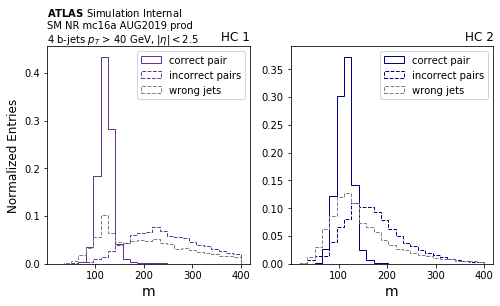

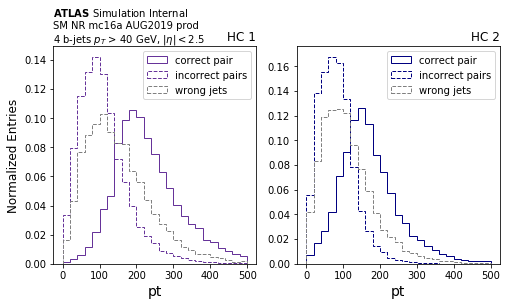

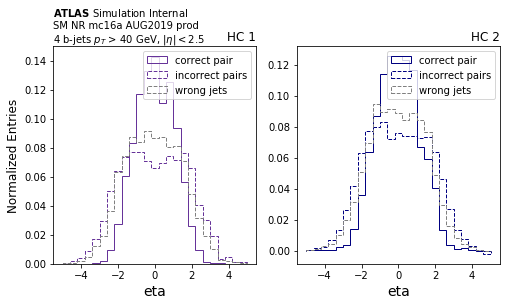

In [10]:
nBins = 25

for var,myRange in zip(['m','pt','eta'],[(20,400),(0,500),(-5,5)]):
       
    v1 = df[['pair{}_HC1_{}'.format(pi,var) for pi in range(3)]].values
    v2 = df[['pair{}_HC2_{}'.format(pi,var) for pi in range(3)]].values
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

    for hci, v, ax,c in zip([1,2],[v1,v2],[ax1,ax2],['rebeccapurple','navy']):
    
        ax.hist(v[~badJets][correct_mask],nBins,myRange,
                histtype='step',color=c,label='correct pair',
                weights=df.loc[~badJets,'mc_sf']/norm)
        ax.hist(v[~badJets][incorrect_mask],nBins,myRange,
                histtype='step',color=c,label='incorrect pairs',linestyle='--',
                weights=np.concatenate(np.ones((N,2))*df.loc[~badJets,'mc_sf'].values.reshape(-1,1))/(2*norm))
        ax.hist(v[badJets].reshape(-1), nBins,myRange,histtype='step',
                color="Grey",linestyle='--',label='wrong jets',
                weights=df.loc[badJets,['mc_sf']*3].values.reshape(-1)/(3*badNorm))
        
        ax.set_title('HC {}'.format(hci),loc='right')
        ax.set_xlabel(var,fontsize=14)
        ax.legend()

    ax1.set_ylabel('Normalized Entries',fontsize=12)

    ax1.text(0,1,smText,ha='left',va='bottom',transform=ax1.transAxes)

    plt.savefig('{}/allPairs_{}.pdf'.format(figDir,var),bbox_inches='tight')

    plt.show()
    

Also, it was kind of interesting that the "wrong jets" category is intermediate b/w the other two categories, probably because one of the pairs contains a true HC.

Ok, this is *super* cool! For the SM, most likely we want the smallest mass, or the largest opening angle.

**Question:** Why did I have this intuition that for the SM NR, all of the categories were in the center of the massplane?

I.e, I had this plot that I showed in my [Mar 27th update](https://indico.cern.ch/event/809357/contributions/3372746/attachments/1819198/2974638/Hartman_hh4b_Mar_27_19.pdf), and I thought the conclusion was that *all* of the possible pairs were inside the SR.

<img src="../figures/SMNR_16/2016_triggers/fourGoodJets_massplane.pdf">

But perhaps I'm just seeing this peak b/c of a visual effect for how these 1d distributions are correclated w/r.t. each other, and maybe I didn't make the range wide enough?

Note: I guess I was kind of seeing this effect with the log scale before though, which emphasizes the tails of thd dits

<img src="../figures/SMNR_16/2016_triggers/fourGoodJets_massplane_log.pdf">

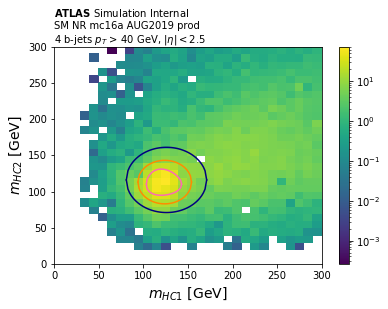

In [31]:
var = 'm'
v1 = df[['pair{}_HC1_{}'.format(pi,var) for pi in range(3)]].values
v2 = df[['pair{}_HC2_{}'.format(pi,var) for pi in range(3)]].values


plt.hist2d(v1.reshape(-1),v2.reshape(-1),30,[(0,300)]*2,
           norm=LogNorm(),#cmap="Pu",
           weights=(np.vstack([df.mc_sf]*3).T).reshape(-1))

plt.xlabel('$m_{HC1}$ [GeV]',fontsize=14)
plt.ylabel('$m_{HC2}$ [GeV]',fontsize=14)

ax = plt.gca()
ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)

for x, y1, y2, c in zip([SR_x,CR_x,SB_x],[SR_y1,CR_y1,SB_y1],
                                [SR_y2,CR_y2,SB_y2],['hotpink','darkorange','navy']):
    ax.plot(x, y1,c)
    ax.plot(x, y2,c)

plt.colorbar()
plt.show()

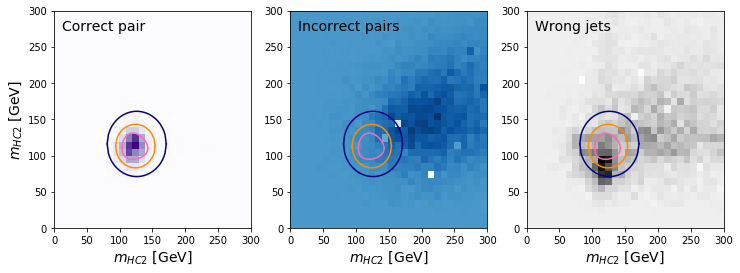

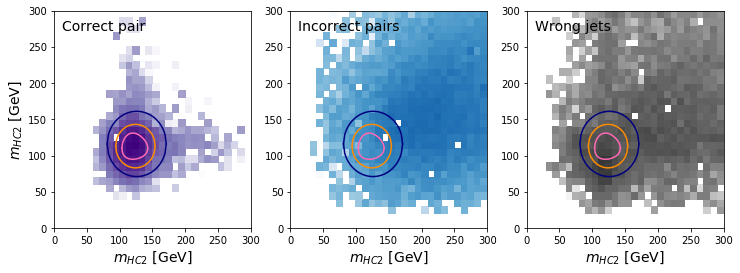

In [32]:
for n,logTag in zip([None,LogNorm()],['','_log']):
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

    ax1.hist2d(v1[~badJets][correct_mask],v2[~badJets][correct_mask],
               30,[(0,300)]*2,cmap="Purples",
               norm=n,weights=df.loc[~badJets,'mc_sf']/norm)

    ax2.hist2d(v1[~badJets][incorrect_mask],v2[~badJets][incorrect_mask],
               30,[(0,300)]*2,cmap="Blues",norm=n,
               weights=np.concatenate(np.ones((N,2))*df.loc[~badJets,'mc_sf'].values.reshape(-1,1))/(2*norm))

    ax3.hist2d(v1[badJets].reshape(-1), v2[badJets].reshape(-1),
               30, [(0,300)]*2, norm=n, cmap="Greys",
               weights=df.loc[badJets,['mc_sf']*3].values.reshape(-1)/(3*badNorm))

    for ax,text in zip([ax1,ax2,ax3],['Correct pair','Incorrect pairs','Wrong jets']):
        ax.set_xlabel('$m_{HC2}$ [GeV]',fontsize=14)
        ax.text(0.04,.96,text,va='top',ha='left',transform=ax.transAxes,fontsize=14)
        
        # Draw the SR, CR, and SB
        for x, y1, y2, c in zip([SR_x,CR_x,SB_x],[SR_y1,CR_y1,SB_y1],
                                [SR_y2,CR_y2,SB_y2],['hotpink','darkorange','navy']):
            ax.plot(x, y1,c)
            ax.plot(x, y2,c)

        
        #plt.colorbar(ax=ax)

    ax1.set_ylabel('$m_{HC2}$ [GeV]',fontsize=14)

    plt.savefig(f'{figDir}/massplane_correctAndIncorrectPairs{logTag}.pdf',bbox_inches='tight')

    plt.show()


Ok, so I'm pretty sure that Michael would want to see these same plots for the background at this point.

In [13]:
# Load in the vectors for the pairing options
pair0_hc1 = TLorentzVectorArray.from_ptetaphim(df.pair0_HC1_pt,df.pair0_HC1_eta,
                                               df.pair0_HC1_phi,df.pair0_HC1_m)

pair0_hc2 = TLorentzVectorArray.from_ptetaphim(df.pair0_HC2_pt,df.pair0_HC2_eta,
                                               df.pair0_HC2_phi,df.pair0_HC2_m)


pair1_hc1 = TLorentzVectorArray.from_ptetaphim(df.pair1_HC1_pt,df.pair1_HC1_eta,
                                               df.pair1_HC1_phi,df.pair1_HC1_m)

pair1_hc2 = TLorentzVectorArray.from_ptetaphim(df.pair1_HC2_pt,df.pair1_HC2_eta,
                                               df.pair1_HC2_phi,df.pair1_HC2_m)

pair2_hc1 = TLorentzVectorArray.from_ptetaphim(df.pair2_HC1_pt,df.pair2_HC1_eta,
                                               df.pair2_HC1_phi,df.pair2_HC1_m)

pair2_hc2 = TLorentzVectorArray.from_ptetaphim(df.pair2_HC2_pt,df.pair2_HC2_eta,
                                               df.pair2_HC2_phi,df.pair2_HC2_m)


In [14]:
for i, (hc1, hc2) in enumerate(zip([pair0_hc1,pair1_hc1,pair2_hc1],[pair0_hc2,pair1_hc2,pair2_hc2])):
    
    df['pair{}_dr'.format(i)] = hc1.delta_r(hc2)
    df['pair{}_deta'.format(i)] = np.abs(hc1.eta - hc2.eta)
    

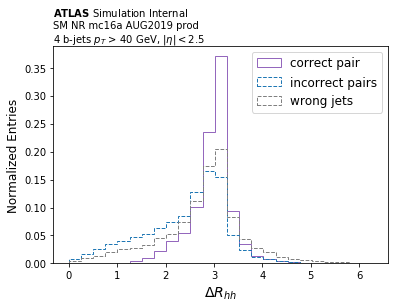

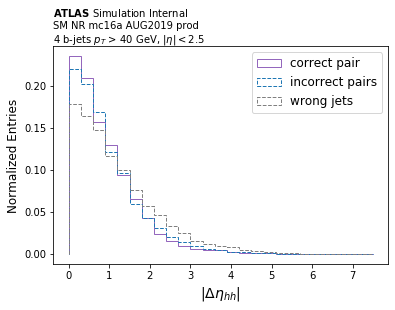

In [30]:
for var,xlabel,myRange in zip(['dr','deta'],['$\Delta R_{hh}$','$|\Delta \eta_{hh}|$'],[(0,2*np.pi),(0,7.5)]):
       
    v = df[['pair{}_{}'.format(pi,var) for pi in range(3)]].values
        
    fig,ax = plt.subplots(1,1)
        
    ax.hist(v[~badJets][correct_mask],nBins,myRange,
            histtype='step',color='C4',label='correct pair',
            weights=df.loc[~badJets,'mc_sf']/norm)
    ax.hist(v[~badJets][incorrect_mask],nBins,myRange,
            histtype='step',color='C0',label='incorrect pairs',linestyle='--',
            weights=np.concatenate(np.ones((N,2))*df.loc[~badJets,'mc_sf'].values.reshape(-1,1))/(2*norm))
    ax.hist(v[badJets].reshape(-1), nBins,myRange,histtype='step',
            color="Grey",linestyle='--',label='wrong jets',
            weights=df.loc[badJets,['mc_sf']*3].values.reshape(-1)/(3*badNorm))

    ax.set_xlabel(xlabel,fontsize=14)
    ax.legend(fontsize='12')

    ax.set_ylabel('Normalized Entries',fontsize=12)

    ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)

    plt.savefig('{}/allPairs_{}.pdf'.format(figDir,var),bbox_inches='tight')

    plt.show()



Interesting... the correct pair is more likely to be back-to-back.

**Question:** What correlation plots would it be useful to look at?

## 2. Comparison between two pairing algs with the correct / incorrect pairs

Ok, so I've never looked at the weighted cutflow for the min $\Delta R_{jj}^{HC1}$ pairing, so it would be nice to see what this looks like.

In [16]:
sum_weights_initial = 0
treeName = "MetaData_EventCount_XhhMiniNtuple"

for myFile in glob(fileDir[physicsSample] + "user.*.MiniNTuple.root"):
    #print(myFile)
    metadata = uproot.open(myFile)[treeName]
    sum_weights_initial += metadata.allvalues[3]

print("sum_weights_initial",sum_weights_initial)

sum_weights_initial 26458.627422725625


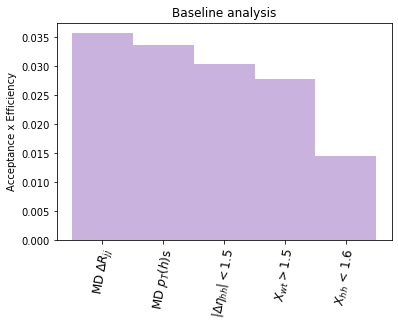

In [17]:
x = ['XhhCommon preselection','trigger',
     '4 b-jets $p_T > 40$ GeV, $|\eta| < 2.5$',
     'MD $\Delta R_{jj}$', 'MD $p_T(h)$s',
     '$|\Delta \eta_{hh}| < 1.5$','$X_{wt} > 1.5$',
     '$X_{hh}$ < 1.6']
    
base_masks = [np.ones_like(df.index).astype(bool), df['2016_triggers'],
              df.fourGoodJets, df.MDR, 
              df.MDpT, df.cut_deta_hh,
              df.cut_Xwt, df.cut_Xhh]

#if btags == '4b':
bmask = (df.nbtags >= 4)
base_masks = [mi & bmask for mi in base_masks]

# Then also look at the impact of XhhCommon on the events 
cf_masks = base_masks

counts = [df.loc[mask,'mc_sf'].sum() / sum_weights_initial 
          for mask in cf_masks]

plt.figure()
#plt.bar(x,counts,width=1,alpha=0.5,color='C4')
plt.bar(x[3:],counts[3:],width=1,alpha=0.5,color='C4')
plt.xticks(x[3:],x[3:],rotation=80,fontsize=12)
plt.ylabel('Acceptance x Efficiency')
plt.title('Baseline analysis')
#plt.savefig('{}/weighted_cutflow.pdf'.format(figDir),bbox_inches='tight')
plt.show()

In [18]:
counts[3:]

[0.0356834114873851,
 0.03365968894597955,
 0.030455581364756585,
 0.02776412433461361,
 0.014483603769582378]

In [19]:
sum_weights_initial*counts[-1]/100

3.8321627587776455

Also, I would kind of like to see what we can do in terms of the accurate / inaccurate pairs here.

Ok, something is fucked, but I don't know what.

## 3. Signal efficiency through the cutflow of our analysis 